In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../final-project-dukeNG2012/My_Raw_Data/anime_28_11_2023.csv')

In [7]:
#! data preprocessing 
df = df.drop(columns=['post_id','user_url','image_id','comments_full','user_id','links','reactors','image_id','sharers','text','shared_username','shared_user_id','factcheck','shared_post_id','shared_time','images_lowquality_description','w3_fb_url','link','shared_post_url','video_thumbnail','video_watches','video_width','shared_text','original_text','image','images','timestamp','images_description','images_lowquality','page_id','video','video_duration_seconds','video_height','video_id','video_quality','video_size_MB','image_ids','was_live','is_live','available','username','fetched_time','with'])
df= df.sort_values(by='time',ascending=True,ignore_index=True)
df['post_ID'] = np.arange(1,121,1)
df['time'] = pd.to_datetime(df['time']) #! convert to date time to take the day in that month. we only have 100 post from 29/10 to 15/11 Bởi vậy chắc chắn các ngày đăng là unique. 

In [8]:
for i in range(3):
    value = str({'like':df['likes'].iloc[i]})
    df['reactions'].iloc[i] = value

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21924\1026809204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reactions'].iloc[i] = value
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21924\1026809204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reactions'].iloc[i] = value
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21924\1026809204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reactions'].iloc[i] = value


In [9]:
like = []
love = []
haha = []
wow = []
care = []
sad = []
angry = []
for i in range(0,120):
    react_row = df.iloc[i]
    reaction = dict(eval(react_row['reactions']))
    like.append(reaction['like'])
    if 'haha' not in reaction:
        reaction['haha'] = 0
    haha.append(reaction['haha'])
    if 'care' not in reaction:
        reaction['care'] = 0
    care.append(reaction['care'])
    if 'wow' not in reaction:
        reaction['wow'] = 0
    wow.append(reaction['wow'])
    if 'sad' not in reaction:
        reaction['sad'] = 0
    sad.append(reaction['sad'])
    if 'angry' not in reaction:
        reaction['angry'] = 0
    angry.append(reaction['angry'])
    if 'love' not in reaction:
        reaction['love'] = 0
    love.append(reaction['love'])
share = df['shares']
comment = df['comments']
Total_reactions = pd.DataFrame({'post_ID': df['post_ID'], 'like':like, 'love':love,'haha':haha,'wow':wow,'care':care,'sad':sad,'angry':angry,'share':share,'comment':comment})

<Axes: >

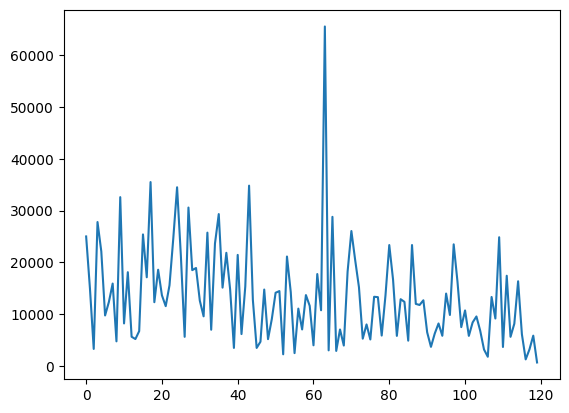

In [14]:
#! Làm linear regression với 60 bài viết đầu, 60 bài sau là để validation
df['reaction_count'].plot(kind='line')

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim

In [80]:
y = df['reaction_count']
x = df['post_ID']
#dataset = pd.DataFrame({'Post_ID':x,'reaction_count':y})

In [119]:
class PolyLinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super().__init__()
        self.linear = nn.Linear(input_dim * degree, output_dim)

    def forward(self, x):
        # Expand the input features to accommodate higher polynomial degrees
        expanded_features = torch.ones((x.shape[0], input_dim * degree), device=x.device)
        for i in range(1, degree + 1):
            expanded_features[:, i * input_dim : (i + 1) * input_dim] = torch.pow(x, i)

        # Predict the output using the linear layer
        y_pred = self.linear(expanded_features)
        
        return y_pred.double()

In [120]:
# Load or generate your training data (x, y)
x = torch.tensor(x,dtype=torch.float64).reshape(120,1)
y = torch.tensor(y,dtype=torch.float64)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21924\1431995569.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype=torch.float64).reshape(120,1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21924\1431995569.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y,dtype=torch.float64)


In [121]:
x.shape

torch.Size([120, 1])

In [166]:
degree = 2  # Specify the polynomial degree
input_dim = x.shape[1] # Number of input features #! 120,1
output_dim = 1  # Number of output features

model = PolyLinearRegression(input_dim, output_dim, degree)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
n_epochs = 100  # Number of training epochs

for epoch in range(n_epochs):
    # Forward pass: Compute predicted outputs
    y_pred = model(x)

    # Loss calculation: Mean squared error (MSE)
    loss = nn.MSELoss()(y_pred, y)

    # Backward pass: Compute gradients using automatic differentiation
    optimizer.zero_grad()
    loss.backward()

    # Update model parameters
    optimizer.step()


In [167]:
y_pred[3]

tensor([794.5793], dtype=torch.float64, grad_fn=<SelectBackward0>)

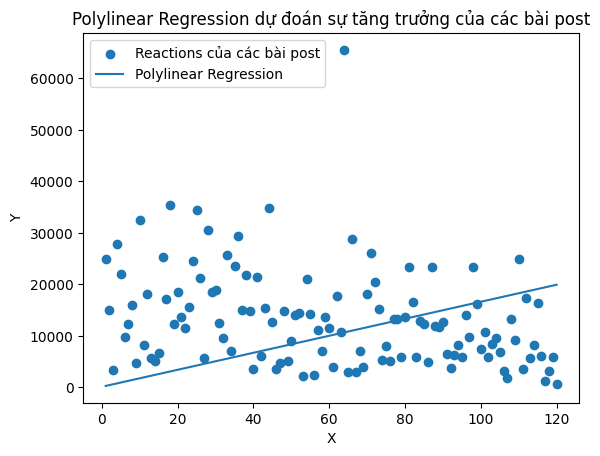

In [169]:
# Create the plot
x_plot = np.arange(1,121,1)
y_pred_array = y_pred
plt.scatter(x, y, label='Reactions của các bài post')
plt.plot(x_plot, y_pred_array.detach().numpy(), label='Polylinear Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Polylinear Regression dự đoán sự tăng trưởng của các bài post')
plt.legend()
plt.show()